# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 1 Lets equip all the necessary tools

In [6]:
import numpy as np
import pandas as pd
import datetime
import os
import inspect
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
import pickle

# 2 Data Preparation 

## 2.1 Load Dataset

In [8]:
#getting the data
src_file_path = 'C:\\Users\\Admin\\github\\First flask Project'
#src_file_path = inspect.getfile(lambda: None)
#this_dir, this_filename = os.path.split(__file__)
path_store_csv =os.path.join(src_file_path, "data", "Rossmann Stores Data.csv")
store_df = pd.read_csv(path_store_csv)

path_sales_csv = os.path.join(src_file_path, "data", "Stores Data.csv")
sales_df = pd.read_csv(path_sales_csv, parse_dates = ['Date'])

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Admin\\github\\First flask Project\\data\\Rossmann Stores Data.csv'

#2.2  Data Cleaning

In [ ]:
# Replace missing values in CompetitionDistance with median for the store dataset
store_df.CompetitionDistance.fillna(store_df.CompetitionDistance.median(), inplace=True)


In [ ]:
# Lets merge both the files
df=pd.merge(sales_df,store_df,how='left',on='Store')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
# Lets get year, month, date from current date

def GetYear(date):
  return date.year

def GetMonth(date):
  return date.month

def GetDay(date):
  return date.day



df['Year'] = df['Date'].apply(GetYear)
df['Month'] = df['Date'].apply(GetMonth)
df['Day'] = df['Date'].apply(GetDay)

In [ ]:
# Function to get competition age
def GetCompetitionAge(year,month,date):

  #Initiating with a variable for age
  age=0

  # Comparing the Competition open time with current time
  if date.year>year:
    age+= (date.year-year)*12 + (date.month - month)

  elif date.year == year and date.month>month:
    age+= date.month - month

  return age

In [ ]:
df['CompetitionAge'] = df.apply(lambda x: GetCompetitionAge(x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth,x.Date), axis=1)

In [ ]:
# There are 3 types of intervals followed by different stores indicating the month in which promo2 new rounf is started
# Lets generate a binary variable showing if new promo2 round is started in the current month or not

# String to List
df['PromoInterval'] = df['PromoInterval'].str.split(',')  

# Converting months into list of month numbers for easy comparison
def GetMonthNumber(month):
  month_dict = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sept':9,'Oct':10,'Nov':11,'Dec':12}
  return month_dict[month]

def GetNumList(interval):
  numlist=[]
  for month in interval:
    month_num = GetMonthNumber(month)
    numlist.append(month_num)
  return numlist  

In [ ]:
# Function to check promo2 new round

def IsPromo2NewRound(promo_part,promo_year,promo_week,promo_interval,date):

  # Initiating a variable if promo is active
  promo_active = 0
  # Initiating a variable if promo new round is active
  promo_new= 0

  # Taking only stores that are participating in promo2
  if promo_part == 1:
    # Checking if the promo has been activated
    if date.year == promo_year and date.week >= promo_week :
      promo_active = 1

    elif date.year > promo_year :
      promo_active = 1

    if promo_active == 1:
      
      #Getting month_number for easy comparison
      promo_months = GetNumList(promo_interval)
      #Checking if new round is started in current month
      if date.month in promo_months:
        promo_new = 1

  return promo_new

In [ ]:
df['Promo2New'] = df.apply( lambda x : IsPromo2NewRound(x.Promo2,x.Promo2SinceYear,x.Promo2SinceWeek,x.PromoInterval,x.Date),axis=1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,CompetitionAge,Promo2New
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,82.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"[Jan, Apr, Jul, Oct]",2015,7,31,92.0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"[Jan, Apr, Jul, Oct]",2015,7,31,103.0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,70.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,3.0,0


In [ ]:
# Converting all number 0 to string '0' for no holiday
df['StateHoliday'][df['StateHoliday']==0] = '0'

In [ ]:
df.drop(df[(df['Sales']==0) & (df['Open']==1)].index,inplace=True)

#3 Feature Engineering

In [ ]:
# Making a copy of df
df1 = df.copy()

In [ ]:
# One hot encoding for categorical features
df1=pd.concat([df1,pd.get_dummies(df1['StateHoliday'],prefix='holy')],axis=1).drop(['StateHoliday'],axis=1)
df1=pd.concat([df1,pd.get_dummies(df1['StoreType'],prefix='type')],axis=1).drop(['StoreType'],axis=1)
df1=pd.concat([df1,pd.get_dummies(df1['Assortment'],prefix='assort')],axis=1).drop(['Assortment'],axis=1)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,CompetitionAge,Promo2New,holy_0,holy_a,holy_b,holy_c,type_a,type_b,type_c,type_d,assort_a,assort_b,assort_c
0,1,5,2015-07-31,5263,555,1,1,1,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,82.0,0,1,0,0,0,0,0,1,0,1,0,0
1,2,5,2015-07-31,6064,625,1,1,1,570.0,11.0,2007.0,1,13.0,2010.0,"[Jan, Apr, Jul, Oct]",2015,7,31,92.0,1,1,0,0,0,1,0,0,0,1,0,0
2,3,5,2015-07-31,8314,821,1,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,"[Jan, Apr, Jul, Oct]",2015,7,31,103.0,1,1,0,0,0,1,0,0,0,1,0,0
3,4,5,2015-07-31,13995,1498,1,1,1,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,70.0,0,1,0,0,0,0,0,1,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,1,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,3.0,0,1,0,0,0,1,0,0,0,1,0,0


In [ ]:
# Number of Customers will not be available for predictions, so we cannot use it directly in our model.
# Customers change according to week-day, date of the month ,month of the year, 
# so lets use average of customers in the past as a feature for future predictions.
# Calculating monthly, weekly and date-wise average of customers in the past
# (excluding last 6 weeks as we will use that in test set)
# We will do this at store level 

last_date = df1['Date'].max() - datetime.timedelta(42) 
past_df = df1[df1['Date']<=last_date]

monthly_avg_cust_df = past_df.groupby(['Store','Month'])['Customers'].mean().reset_index().rename(columns={'Customers':'Month_Avg_Cust'})
weekday_avg_cust_df = past_df.groupby(['Store','DayOfWeek'])['Customers'].mean().reset_index().rename(columns={'Customers':'Week_Day_Avg_Cust'})
date_avg_cust_df = past_df.groupby(['Store','Day'])['Customers'].mean().reset_index().rename(columns={'Customers':'Day_Avg_Cust'})
 

df1 = pd.merge(df1,monthly_avg_cust_df,how='left',on=['Store','Month']) 
df1 = pd.merge(df1,weekday_avg_cust_df,how='left',on=['Store','DayOfWeek']) 
df1 = pd.merge(df1,date_avg_cust_df,how='left',on=['Store','Day'])   

In [ ]:
# Coverting avg customers into int
df1['Month_Avg_Cust'] = df1['Month_Avg_Cust'].astype(int)
df1['Week_Day_Avg_Cust'] = df1['Week_Day_Avg_Cust'].astype(int)
df1['Day_Avg_Cust'] = df1['Day_Avg_Cust'].astype(int)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,CompetitionAge,Promo2New,holy_0,holy_a,holy_b,holy_c,type_a,type_b,type_c,type_d,assort_a,assort_b,assort_c,Month_Avg_Cust,Week_Day_Avg_Cust,Day_Avg_Cust
0,1,5,2015-07-31,5263,555,1,1,1,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,82.0,0,1,0,0,0,0,0,1,0,1,0,0,463,539,460
1,2,5,2015-07-31,6064,625,1,1,1,570.0,11.0,2007.0,1,13.0,2010.0,"[Jan, Apr, Jul, Oct]",2015,7,31,92.0,1,1,0,0,0,1,0,0,0,1,0,0,559,534,401
2,3,5,2015-07-31,8314,821,1,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,"[Jan, Apr, Jul, Oct]",2015,7,31,103.0,1,1,0,0,0,1,0,0,0,1,0,0,654,748,617
3,4,5,2015-07-31,13995,1498,1,1,1,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,70.0,0,1,0,0,0,0,0,1,0,0,0,1,1069,1243,1235
4,5,5,2015-07-31,4822,559,1,1,1,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,3.0,0,1,0,0,0,1,0,0,0,1,0,0,498,540,343


In [ ]:
# Removing all features that are not useful any more
df1.drop(columns =['Customers','CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'], inplace=True) 

Sales_logt -1.7037453210839324
CompetitionDistance_logt -0.35396319391457104
CompetitionAge_logt -0.04094635472635534


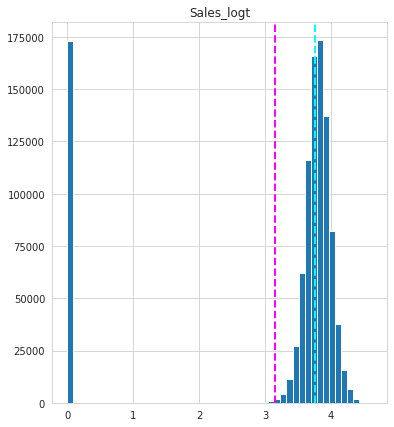

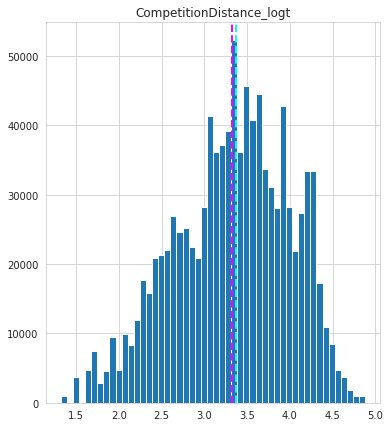

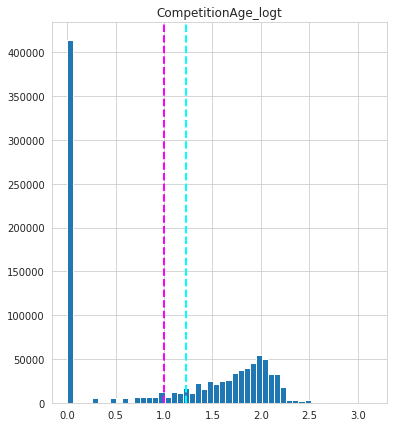

In [ ]:
# We need to normalise our data and reduce skewness for our regression task to work properly
df1['Sales_logt'] = df1['Sales'].apply(lambda x: np.log10(x+1))
df1['CompetitionDistance_logt'] = df1['CompetitionDistance'].apply(lambda x: np.log10(x+1))
df1['CompetitionAge_logt'] = df1['CompetitionAge'].apply(lambda x: np.log10(x+1))



#4 Model building

#5 Train-Test Split

In [ ]:
# We will split data on time basis and keep last 6 weeks of data in the test set
# We use Date for spliting after which we can drop the feature 
last_date = df1['Date'].max()
date_before_six_weeks = last_date - datetime.timedelta(days=42)

# This should be the last date in out train set, so lets find the respective index

train_set_first_index = df1[df1['Date']==date_before_six_weeks].first_valid_index()

print('Last Date :' , last_date ,'\n'
      'Date Before Six Weeks :', date_before_six_weeks,'\n'
      'Train Set First Index :', train_set_first_index)

Last Date : 2015-07-31 00:00:00 
Date Before Six Weeks : 2015-06-19 00:00:00 
Train Set First Index : 46830


In [ ]:
# Lets split the data
train_df = df1[train_set_first_index :]
test_df = df1[: train_set_first_index]
print('Train df :', train_df.shape,'\n'
      'Test df :' , test_df.shape)

Train df : (970325, 31) 
Test df : (46830, 31)


In [ ]:
# Defining our variables for model
X_train = train_df.drop(columns=['Date','Sales','Sales_logt','CompetitionDistance', 'CompetitionAge'])
X_test = test_df.drop(columns=['Date','Sales','Sales_logt','CompetitionDistance', 'CompetitionAge'])
y_train = train_df['Sales_logt']
y_test = test_df['Sales_logt']

In [ ]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [ ]:
# Evaulation metrix 
# We need to inverse transform our varaibles for evaulting the model
def rmse(x, y):

    return sqrt(mean_squared_error(10**x-1, 10**y-1))

def R2_score(x,y):
  return r2_score(10**x-1,10**y-1)    

#6 Model Selection

In [ ]:
# Making a function to use RF and predict sales for 6 weeks
# This function will take pre-cleaned train and test set as input and will give sales priction as output
# We are assuming here that the store open/close info is available before hand and is planned
# Test set will not contain daily customer data
# Apart from train,test set , this function will take our model with hyper-parameters as input

def PredictSalesUsingRF(train_set,validation_set,best_model):
 
  # Defining our variables for model
  # Taking only the required features
  X_training = train_set.drop(columns=['Date','Sales','Sales_logt','CompetitionDistance', 'CompetitionAge'])
  X_validation = validation_set.drop(columns=['Date','Sales','Sales_logt','CompetitionDistance', 'CompetitionAge'])
  y_training = train_set['Sales_logt']
  y_validation = validation_set['Sales_logt']

  # Applying standardization on dependant variables
  stdardize = StandardScaler()
  X_training_std = stdardize.fit_transform(X_training)
  X_validation_std = stdardize.transform(X_validation)

  # Fitting our model with training set
  RF_fit = best_model.fit(X_training_std, y_training)

  # Predicting on train & validation set
  pred_on_training = RF_fit.predict(X_training_std)
  pred_on_validation = RF_fit.predict(X_validation_std)

  # Avaluating the predictions
  train_rmse = rmse(y_training, pred_on_training)
  validation_rmse = rmse(y_validation, pred_on_validation)
  train_r2_score = R2_score(y_training, pred_on_training)
  validation_r2_score = R2_score(y_validation, pred_on_validation)
  
  # Printing the evaluation matrices
  print("Training RMSE", ":", train_rmse ,
        "Validation RMSE", ":", validation_rmse)
  print("Training R2_Score", ":",train_r2_score ,
        "Validation R2_Score", ":",validation_r2_score)
  
  # Output df, concating our predictions with store id and date
  output_df =pd.DataFrame()
  output_df['Store'] =  validation_set['Store']
  output_df['Date'] =  validation_set['Date']
  # We need to inverse-transform the predicted values as we have used log transform
  output_df['Predicted_Sales'] = 10**pred_on_validation-1
  return output_df,RF_fit

In [ ]:
# Defining train set, validation set and our model
train_set = train_df.copy()
validation_set = test_df.copy()

# Using best hyper-parameters obtained by GridSearchCV
our_model = RandomForestRegressor(max_depth = 40, min_samples_leaf= 3,n_estimators= 40)

# Using our function
output_predicted_sales,fitted_model = PredictSalesUsingRF(train_set,validation_set,our_model)
print(output_predicted_sales)

In [ ]:
pickle.dump(fitted_model, open('models/final_prediction.pickle', 'wb'))